In [1]:
import numpy as np

import torch
import rlkit.torch.pytorch_util as ptu
from kornia.geometry.transform import warp_perspective, get_perspective_transform, get_rotation_matrix2d, warp_affine
from rlkit.data_management.obs_dict_replay_buffer import ObsDictReplayBuffer
from rlkit.misc.wx250_utils import add_data_to_buffer_real_robot, DummyEnv

import matplotlib.pyplot as plt
import os
gpu_id = 0
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = str(gpu_id)
ptu.set_gpu_mode(True)

In [2]:
BUFFER_PATH = "/nfs/kun1/users/jonathan/bridge_data/put_broccoli_in_bowl/train/out.npy"

In [3]:
data = np.load(BUFFER_PATH, allow_pickle=True)

In [4]:
data[0]['observations'].shape

(27, 3, 49152)

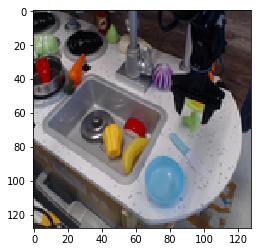

In [5]:
plt.imshow(data[0]['observations'][10][0].reshape(3, 128, 128).transpose(1, 2, 0))

In [6]:
expl_env = DummyEnv(image_size=64, use_wrist=True)
replay_buffer = ObsDictReplayBuffer(
    int(1E6),
    expl_env,
    observation_keys=['image', 'state']
)
add_data_to_buffer_real_robot(BUFFER_PATH, replay_buffer)

Failed to open /nfs/kun1/users/jonathan/bridge_data/put_broccoli_in_bowl/train/out.npy


UnboundLocalError: local variable 'data' referenced before assignment

In [7]:
print(replay_buffer._rewards[:replay_buffer._size].sum() / replay_buffer._size)
reward_rates = []
num_success = 0
for i in range(30000 // 15):
    traj = replay_buffer._rewards[15 * i:15 * (i + 1)]
    if 1 in traj:
        reward_rates.append(replay_buffer._rewards[15 * i:15 * (i + 1)].sum())
        num_success += 1
print(np.mean(reward_rates))
print(num_success / (30000 // 15))

nan
15.0
1.0


/home/jonathan/anaconda3/envs/railrl-env/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in double_scalars
  """Entry point for launching an IPython kernel.


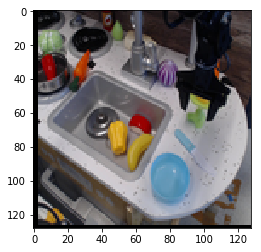

In [24]:
obs = data[0]['observations'][10][0].reshape(3, 128, 128).astype(np.float32) / 255.0
#plt.imshow(obs.transpose(1, 2, 0))
obs = ptu.from_numpy(obs.reshape(1, 3, 128, 128))
'''
dst_jitter = np.random.uniform(-6, 6, size=(1, 4, 2))
src = np.array([[[0, 0], [0, 64], [64, 0], [64, 64]]])
dst = np.clip(src - dst_jitter, 0, 64)
src = ptu.from_numpy(src)
dst = ptu.from_numpy(dst)
obs = warp_perspective(obs, get_perspective_transform(src, dst), dsize=(64, 64))
'''
from rlkit.torch.networks.cnn import WarpPerspective, RandomCrop
transform = RandomCrop(128, 4)
obs = transform(obs)
obs = obs.detach().cpu().numpy()[0]
plt.imshow(obs.transpose((1, 2, 0)))

In [40]:
success_idxs = []
for i in range(100000):
    if replay_buffer._rewards[i] == 1:
        success_idxs.append(i)
        


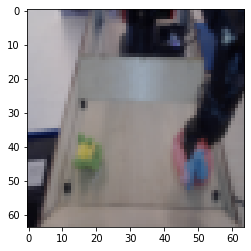

In [46]:
obs = replay_buffer._obs['image'][success_idxs[60]]
plt.imshow(obs.reshape(3, 64, 64).transpose((1, 2, 0)))